## Remaining Useful Life Prediction of Jet Engines using NASA C-MAPSS Dataset                                                 

Prognostics and Health Management (PHM) plays a vital role in modern industry by predicting the health state of machinery and reducing unexpected failures and downtime. This project uses the **NASA C-MAPSS dataset** to build a machine learning model that can estimate the **Remaining Useful Life (RUL)** of aircraft engines.

The dataset consists of run-to-failure simulated data from a fleet of turbo fan jet engines. Each engine is monitored across multiple operating cycles with **21 different sensor** measurements and **3 operational settings**. The data captures how faults evolve over time, providing a rich base for time series modeling and RUL estimation.

By training on complete run-to-failure sequences and predicting RUL for truncated test sequences, the goal is to help anticipate failures before they occur—enabling predictive maintenance in real-world aerospace systems.

### Why Predicting Remaining Useful Life (RUL) Is Important
* Remaining Useful Life (RUL) estimates play a pivotal role in various domains, including aircraft engines, medical equipment, and power plants.

* Expressed in units of time (such as hours or cycles), RUL informs decision-makers about the remaining operational cycles before equipment failure.

* By subjectively determining end-of-life thresholds based on operational conditions, organizations can optimize maintenance schedules, avoid unscheduled repairs, and enhance safety.

* Adjusting operational characteristics, guided by accurate RUL estimates, prolongs component life and ensures a smooth transition from faulty to fully functional equipment.

* Overall, reliable RUL estimation promises substantial cost savings and operational improvements.

<p align="center">
  <img src="../image/Engine.png" width="400"/>
</p>


<p align="center">
  <img src="../image/simulation.png" />
</p>

### 📊 Data Structure:
* The dataset consists of multiple multivariate time series.

* Each dataset is split into training and test subsets.

* Each time series represents an engine, and the data can be considered as coming from a fleet of engines of the same type.

* Engines start with varying degrees of initial wear and manufacturing variation (unknown to the user).

* This wear and variation are considered normal and not indicative of a fault condition.

* The data includes three operational settings that significantly impact engine performance.

* Sensor noise contaminates the data.


### 🔧 Engine Behavior:
* The engine in question is a turbofan engine. It operates normally at the start of each time series.

* At some point during the series, each engine develops a fault due to High Pressure Compressor (HPC) failure.

* In the training set, the fault grows until system failure.

* In the test set, the time series ends before system failure.


### 🎯 Objective:
* The goal is to predict the remaining operational cycles before failure in the test set.

* Specifically, it aims to predict the number of operational cycles after the last cycle that the engine will continue to operate.

* A vector of true Remaining Useful Life (RUL) values is provided for the test data.

#### 📊 Dataset Structure: 26 Columns
Each row in the dataset represents one engine cycle. The columns are:

🔹 Identification & Operational Settings

1. **unit_number** – Engine ID  
2. **time_in_cycles** – Operational cycle count (cycles)  
3. **operational_setting_1**  
4. **operational_setting_2**  
5. **operational_setting_3**  

🔹 Sensor Measurements

6. **T2** – Total temperature at fan inlet (°R)  
7. **T24** – Total temperature at LPC outlet (°R)  
8. **T30** – Total temperature at HPC outlet (°R)  
9. **T50** – Total temperature at LPT outlet (°R)  
10. **P2** – Pressure at fan inlet (psia)  
11. **P15** – Total pressure in bypass duct (psia)  
12. **P30** – Total pressure at HPC outlet (psia)  
13. **Nf** – Physical fan speed (rpm)  
14. **Nc** – Physical core speed (rpm)  
15. **epr** – Engine pressure ratio  
16. **Ps30** – Static pressure at HPC outlet (psia)  
17. **phi** – Ratio of fuel flow to Ps30 (pps/psi)  
18. **NRf** – Corrected fan speed (rpm)  
19. **NRc** – Corrected core speed (rpm)  
20. **BPR** – Bypass ratio  
21. **farB** – Burner fuel-air ratio  
22. **htBleed** – Bleed enthalpy  
23. **Nf_dmd** – Demanded fan speed (rpm)  
24. **PCNfR_dmd** – Demanded corrected fan speed (rpm)  
25. **W31** – HPT coolant bleed (lbm/s)  
26. **W32** – LPT coolant bleed (lbm/s)  

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler


# 1. Load & clean function
def load_data(filepath):
    df = pd.read_csv(filepath, sep='\s+', header=None, engine='python')
    df.dropna(axis=1, inplace=True)
    return df

# 2. File paths
train_files = [
    '../data/train_FD001.txt',
    '../data/train_FD002.txt',
    '../data/train_FD003.txt',
    '../data/train_FD004.txt'
]

test_files = [
    '../data/test_FD001.txt',
    '../data/test_FD002.txt',
    '../data/test_FD003.txt',
    '../data/test_FD004.txt'
]

# 3. Initialize holders
train_dfs = []
test_dfs = []
engine_id_offset = 0

# 4. Process training files
for f in train_files:
    df = load_data(f)
    df[0] += engine_id_offset  # make engine_id unique across files
    df['RUL'] = df.groupby(0)[1].transform('max') - df[1]  # RUL = max cycle - current cycle
    train_dfs.append(df)
    engine_id_offset = df[0].max() + 1  # update offset for next file

# 5. Process test files (same logic as train)
for f in test_files:
    df = load_data(f)
    df[0] += engine_id_offset
    df['RUL'] = df.groupby(0)[1].transform('max') - df[1]
    test_dfs.append(df)
    engine_id_offset = df[0].max() + 1

# 6. Combine all data
train_df = pd.concat(train_dfs, ignore_index=True)
test_df = pd.concat(test_dfs, ignore_index=True)

# 7. Define feature columns (exclude engine_id, cycle, and RUL)
sensor_cols = train_df.columns[2:-1]

# 8. Extract features & labels
X_train = train_df[sensor_cols]
y_train = train_df['RUL'].values.ravel()  # flatten to (n,)
X_test = test_df[sensor_cols]
y_test = test_df['RUL'].values.ravel()    # flatten to (n,)

# 9. Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 10. Print final shapes
print("✅ Final Shapes:")
print("X_train_scaled:", X_train_scaled.shape)
print("y_train:", y_train.shape)
print("X_test_scaled:", X_test_scaled.shape)
print("y_test:", y_test.shape)


✅ Final Shapes:
X_train_scaled: (160359, 24)
y_train: (160359,)
X_test_scaled: (104897, 24)
y_test: (104897,)


In [8]:
print(X_train)

             2       3      4       5       6        7        8      9   \
0       -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60  14.62   
1        0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14  14.62   
2       -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20  14.62   
3        0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87  14.62   
4       -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22  14.62   
...         ...     ...    ...     ...     ...      ...      ...    ...   
160354   9.9998  0.2500  100.0  489.05  605.33  1516.36  1315.28  10.52   
160355   0.0028  0.0015  100.0  518.67  643.42  1598.92  1426.77  14.62   
160356   0.0029  0.0000  100.0  518.67  643.68  1607.72  1430.56  14.62   
160357  35.0046  0.8400  100.0  449.44  555.77  1381.29  1148.18   5.48   
160358  42.0030  0.8400  100.0  445.00  549.85  1369.75  1147.45   3.91   

           10      11  ...      16       17       18      19    20   21    22  \
0       21.61  554

In [9]:
print(y_train)

[191 190 189 ...   2   1   0]


In [22]:
print(X_test)

             2       3      4       5       6        7        8      9   \
0        0.0023  0.0003  100.0  518.67  643.02  1585.29  1398.21  14.62   
1       -0.0027 -0.0003  100.0  518.67  641.71  1588.45  1395.42  14.62   
2        0.0003  0.0001  100.0  518.67  642.46  1586.94  1401.34  14.62   
3        0.0042  0.0000  100.0  518.67  642.44  1584.12  1406.42  14.62   
4        0.0014  0.0000  100.0  518.67  642.51  1587.19  1401.92  14.62   
...         ...     ...    ...     ...     ...      ...      ...    ...   
104892  41.9991  0.8401  100.0  445.00  550.30  1364.40  1129.17   3.91   
104893  20.0026  0.7005  100.0  491.19  608.00  1494.75  1260.88   9.35   
104894  34.9988  0.8413  100.0  449.44  555.92  1370.65  1130.97   5.48   
104895  20.0027  0.7000  100.0  491.19  608.19  1489.11  1256.25   9.35   
104896  35.0075  0.8402  100.0  449.44  556.40  1378.58  1140.70   5.48   

           10      11  ...      16       17       18      19    20   21    22  \
0       21.61  553

In [10]:
print(y_test)

[30 29 28 ...  2  1  0]


In [11]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
import joblib

models = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(max_iter=5000),
    'DecisionTree': DecisionTreeRegressor(),
    'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=15, n_jobs=-1),
    'GradientBoost': GradientBoostingRegressor(),
    'AdaBoost': AdaBoostRegressor(),
    'SVR': SVR(max_iter=5000, tol=1e-2),
    'KNN': KNeighborsRegressor(),
    'MLP': MLPRegressor(max_iter=1000)
}



# Train and Save Models
for name, model in models.items():
    print(f"Training {name} model...")
    model.fit(X_train_scaled, y_train)
    joblib.dump(model, f"../models/{name}.pkl")
joblib.dump(scaler, "../models/scaler.pkl")


Training Linear model...
Training Ridge model...
Training Lasso model...
Training DecisionTree model...
Training RandomForest model...
Training GradientBoost model...
Training AdaBoost model...
Training SVR model...


C:\Users\sanya\AppData\Roaming\Python\Python311\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Training KNN model...
Training MLP model...


['../models/scaler.pkl']

✅ Linear.pkl already exists at e:\Python project\predictRemainLife\models\Linear.pkl
✅ Ridge.pkl already exists at e:\Python project\predictRemainLife\models\Ridge.pkl
✅ Lasso.pkl already exists at e:\Python project\predictRemainLife\models\Lasso.pkl
✅ DecisionTree.pkl already exists at e:\Python project\predictRemainLife\models\DecisionTree.pkl
✅ RandomForest.pkl already exists at e:\Python project\predictRemainLife\models\RandomForest.pkl
✅ GradientBoost.pkl already exists at e:\Python project\predictRemainLife\models\GradientBoost.pkl
✅ AdaBoost.pkl already exists at e:\Python project\predictRemainLife\models\AdaBoost.pkl
✅ SVR.pkl already exists at e:\Python project\predictRemainLife\models\SVR.pkl
✅ KNN.pkl already exists at e:\Python project\predictRemainLife\models\KNN.pkl
✅ MLP.pkl already exists at e:\Python project\predictRemainLife\models\MLP.pkl
✅ scaler.pkl already exists at e:\Python project\predictRemainLife\models\scaler.pkl
⏳ Precomputing predictions for each model...


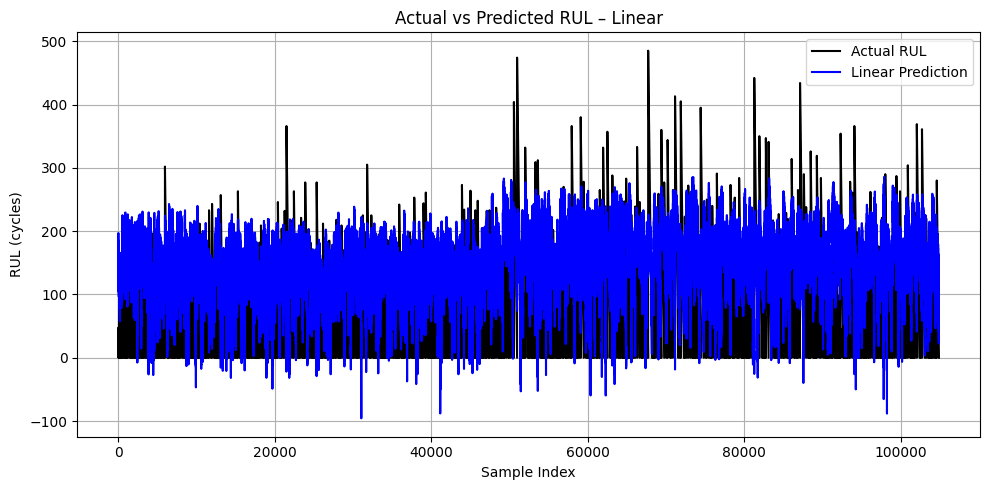

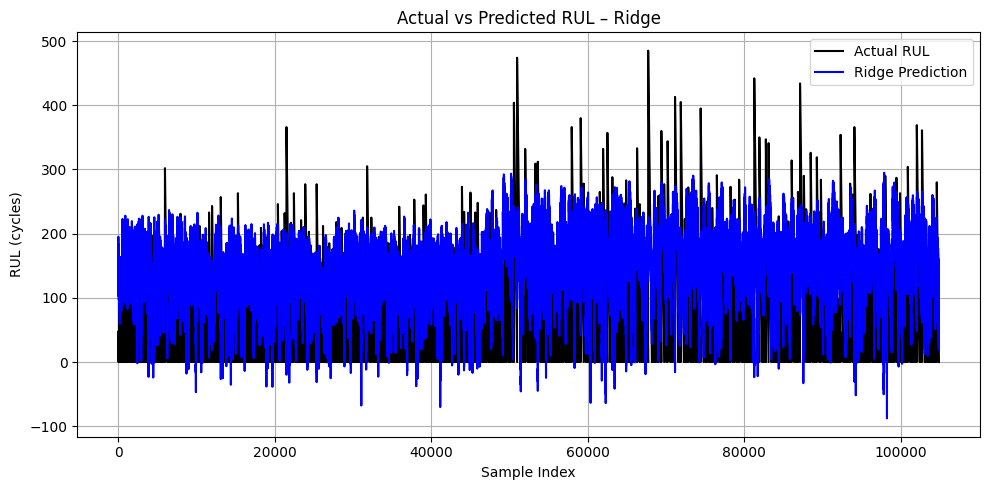

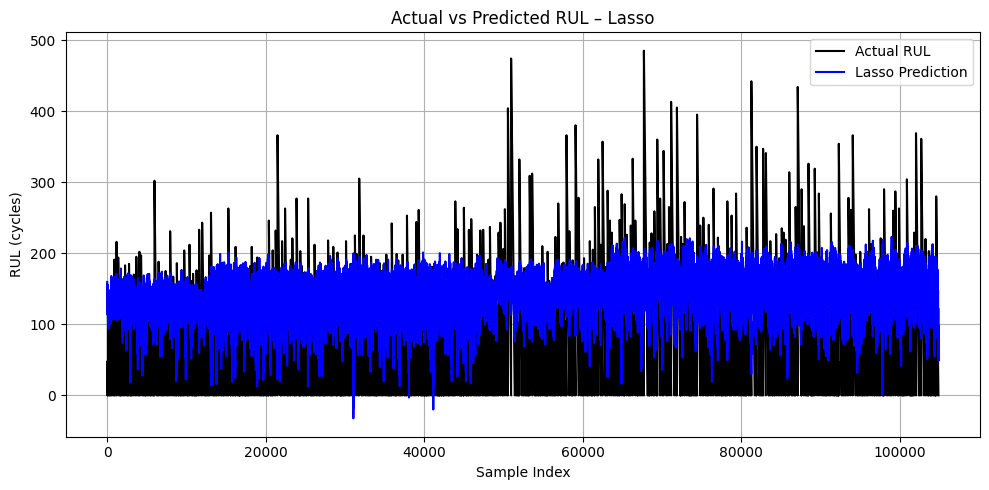

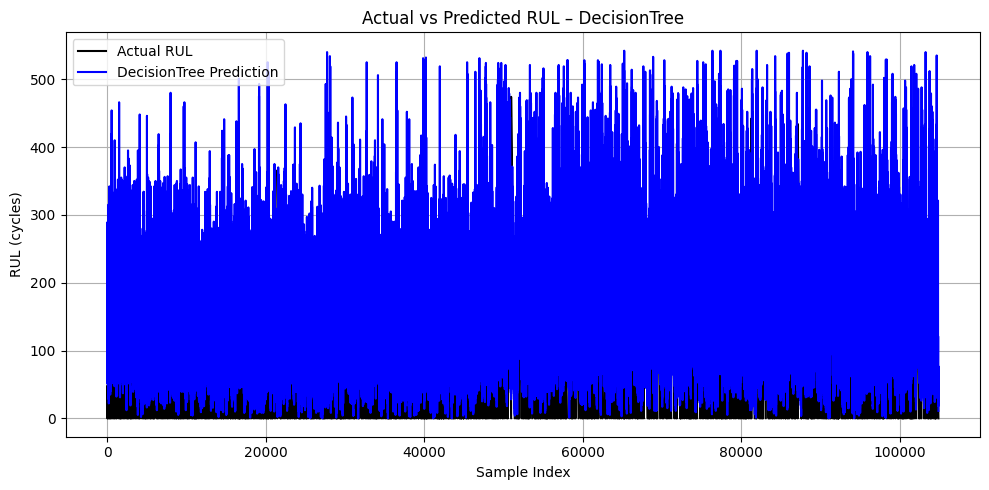

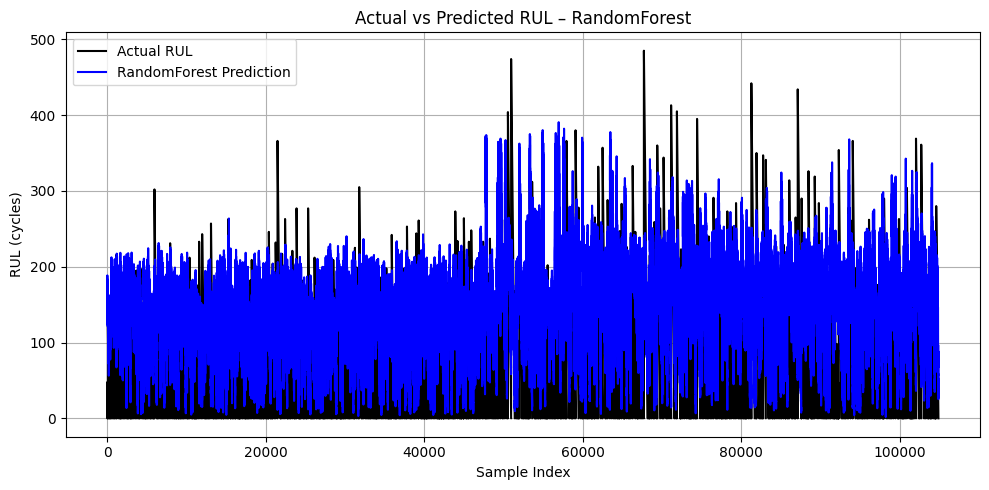

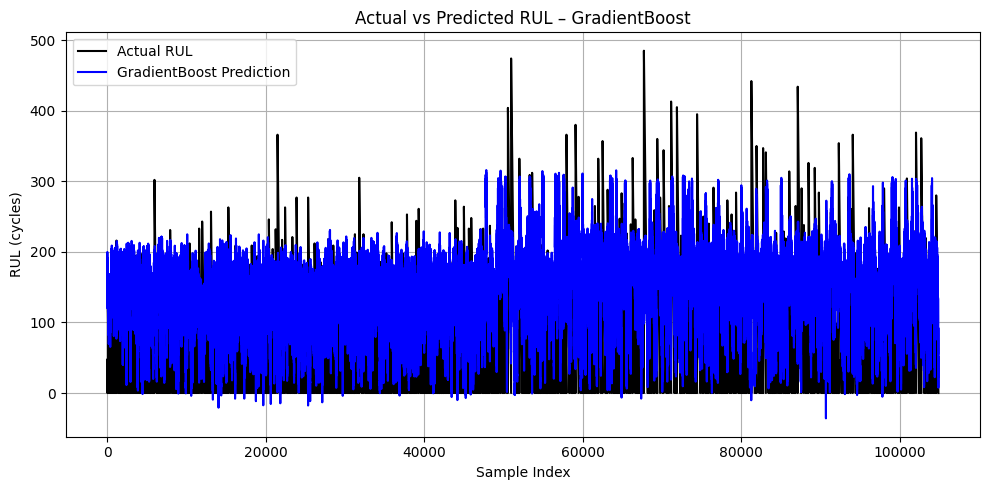

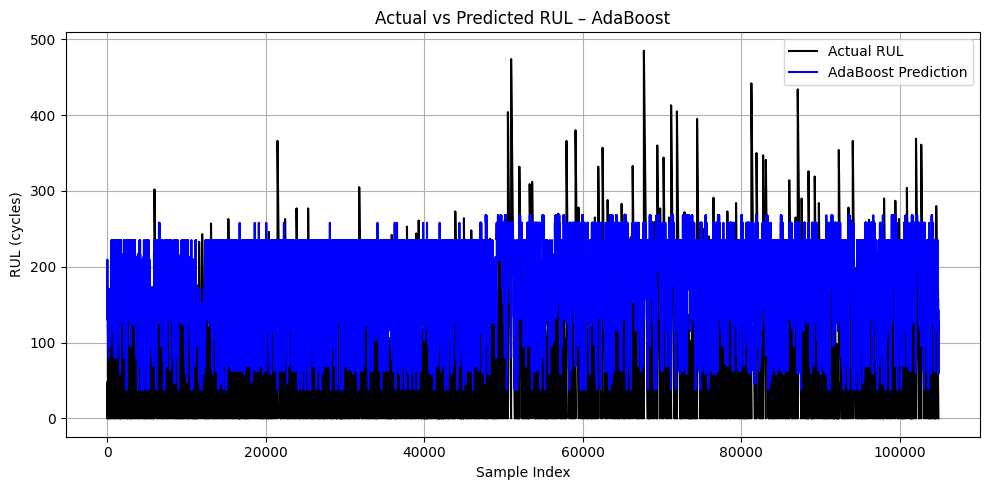

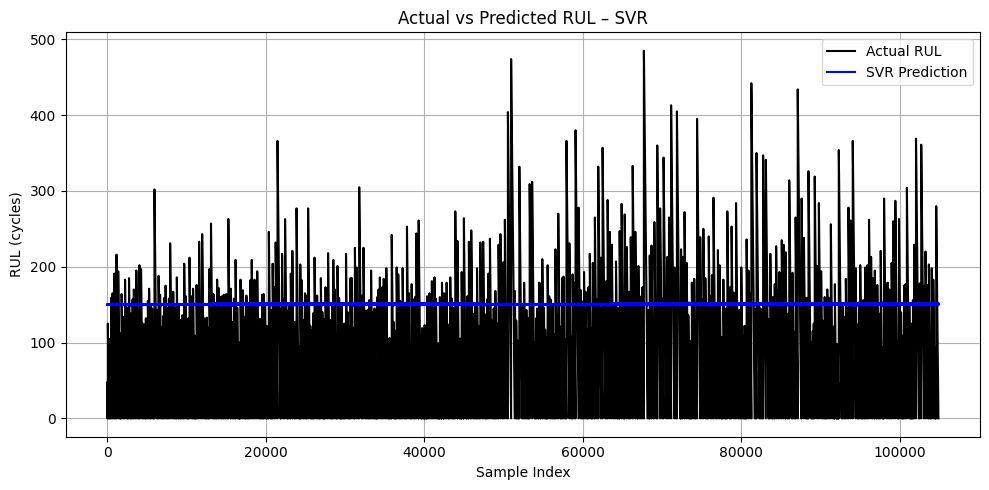

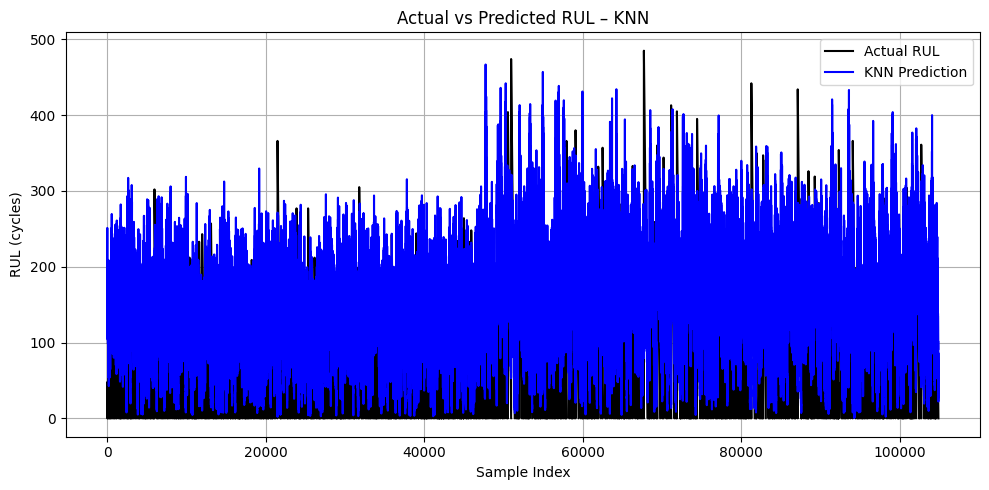

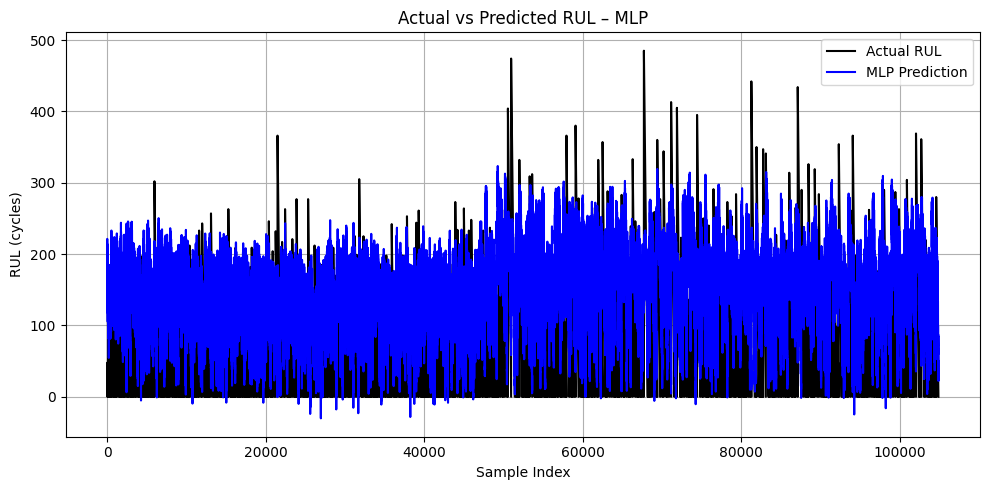

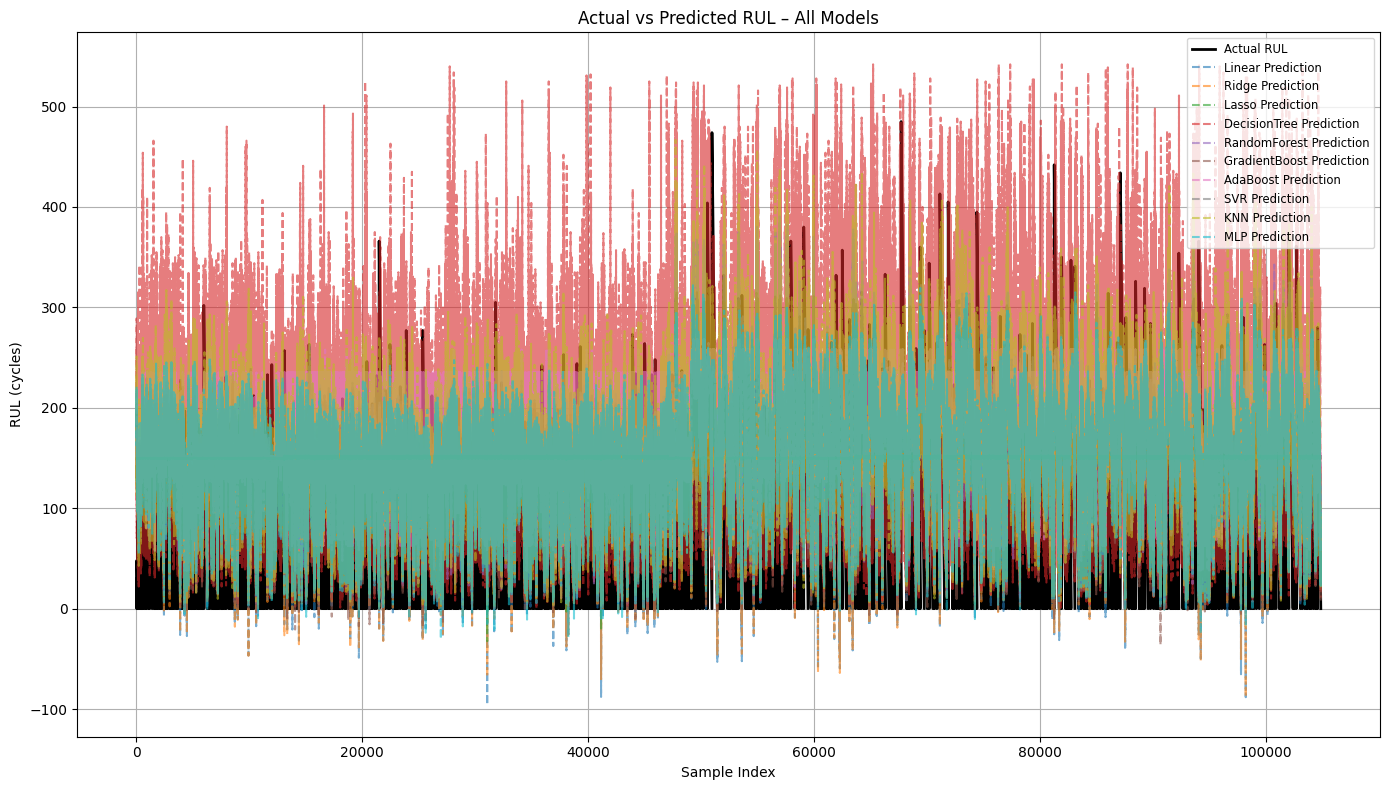


🚀 Starting ensemble combination evaluation...
[100/1023] ✔ Bitset: 0001100100 | MSE: 7906.7904 | R²: -0.4318 | Best MSE: -0.3395
[200/1023] ✔ Bitset: 0011001000 | MSE: 8335.4690 | R²: -0.5095 | Best MSE: -0.1640
[300/1023] ✔ Bitset: 0100101100 | MSE: 8154.9984 | R²: -0.4768 | Best MSE: -0.1640
[400/1023] ✔ Bitset: 0110010000 | MSE: 6845.4821 | R²: -0.2396 | Best MSE: -0.1640
[500/1023] ✔ Bitset: 0111110100 | MSE: 7211.9836 | R²: -0.3060 | Best MSE: -0.1640
[600/1023] ✔ Bitset: 1001011000 | MSE: 8526.2431 | R²: -0.5440 | Best MSE: -0.1640
[700/1023] ✔ Bitset: 1010111100 | MSE: 7587.9508 | R²: -0.3741 | Best MSE: -0.1640
[800/1023] ✔ Bitset: 1100100000 | MSE: 7492.1405 | R²: -0.3567 | Best MSE: -0.1640
[900/1023] ✔ Bitset: 1110000100 | MSE: 7090.8484 | R²: -0.2841 | Best MSE: -0.1640
[1000/1023] ✔ Bitset: 1111101000 | MSE: 7747.7033 | R²: -0.4030 | Best MSE: -0.1640
[1023/1023] ✔ Bitset: 1111111111 | MSE: 7584.9409 | R²: -0.3735 | Best MSE: -0.1640

✅ Finished all combinations.
🏆 Best B

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import joblib
import time
import os
import json
import gdown

# Target models directory (one folder up)
# Go one folder back from current notebook location
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
MODEL_DIR = os.path.join(BASE_DIR, "models")
os.makedirs(MODEL_DIR, exist_ok=True)

# Load file IDs from model_file_ids.json
json_path = os.path.join(BASE_DIR, "model_file_ids.json")
with open(json_path, "r") as f:
    file_ids = json.load(f)

# Download each model if not already present
for name, file_id in file_ids.items():
    dest_path = os.path.join(MODEL_DIR, f"{name}.pkl")

    if not os.path.isfile(dest_path):
        url = f"https://drive.google.com/uc?id={file_id}"
        print(f"📥 Downloading {name}.pkl...")
        gdown.download(url, dest_path, quiet=False)
    else:
        print(f"✅ {name}.pkl already exists at {dest_path}")

# Load model names and trained models
model_names = list(models.keys())
trained_models = {name: joblib.load(f"../models/{name}.pkl") for name in model_names}

# Step 1: Predict once for each model
print("⏳ Precomputing predictions for each model...")
all_preds = []
for name in model_names:
    preds = trained_models[name].predict(X_test_scaled)
    all_preds.append(preds)
    print(f"✅ {name} predicted: shape = {preds.shape}")

import matplotlib.pyplot as plt

for i, name in enumerate(model_names):
    plt.figure(figsize=(10, 5))
    plt.plot(y_test, label='Actual RUL', color='black')
    plt.plot(all_preds[i], label=f'{name} Prediction', color='blue')
    plt.title(f'Actual vs Predicted RUL – {name}')
    plt.xlabel('Sample Index')
    plt.ylabel('RUL (cycles)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(14, 8))
plt.plot(y_test, label='Actual RUL', color='black', linewidth=2)
for i, name in enumerate(model_names):
    plt.plot(all_preds[i], label=f'{name} Prediction', alpha=0.6, linestyle='--')
plt.title("Actual vs Predicted RUL – All Models")
plt.xlabel("Sample Index")
plt.ylabel("RUL (cycles)")
plt.legend(loc='upper right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

# Convert to numpy array of shape (n_models, n_samples)
all_preds = np.array(all_preds)  # shape = (10, n_samples)

print("\n🚀 Starting ensemble combination evaluation...")

best_score = float('-inf')
best_combo = None
metrics_log = {}
total_combos = 2 ** len(model_names) - 1

for i in range(1, total_combos + 1):
    bitset = format(i, f'0{len(model_names)}b')  # e.g. "1010010110"
    selected_idxs = [j for j, b in enumerate(bitset) if b == '1']

    # Step 2: Extract predictions for selected models
    selected_preds = all_preds[selected_idxs]  # shape = (k, n_samples)
    
    # Step 3: Average across selected model predictions
    ensemble_pred = np.mean(selected_preds, axis=0)

    # Step 4: Compute metrics
    mse = mean_squared_error(y_test, ensemble_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, ensemble_pred)
    r2 = r2_score(y_test, ensemble_pred)

    

    # Track best
    if r2 > best_score:
        best_score = r2
        best_combo = bitset
        metrics_log[bitset] = {
            "models": [model_names[j] for j in selected_idxs],
            "MSE": mse,
            "RMSE": rmse,
            "MAE": mae,
            "R2": r2
         }

    # Progress print
    if i % 100 == 0 or i == total_combos:
        print(f"[{i}/{total_combos}] ✔ Bitset: {bitset} | MSE: {mse:.4f} | R²: {r2:.4f} | Best MSE: {best_score:.4f}")

# Final output
print("\n✅ Finished all combinations.")
print(f"🏆 Best Bitset: {best_combo}")
print(f"📦 Best Models: {metrics_log[best_combo]['models']}")
print(f"📉 Best MSE: {metrics_log[best_combo]['MSE']:.4f}")
print(f"📏 Best RMSE: {metrics_log[best_combo]['RMSE']:.4f}")
print(f"📊 Best MAE: {metrics_log[best_combo]['MAE']:.4f}")
print(f"📈 Best R²: {metrics_log[best_combo]['R2']:.4f}")


Available Unit IDs: [714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910,

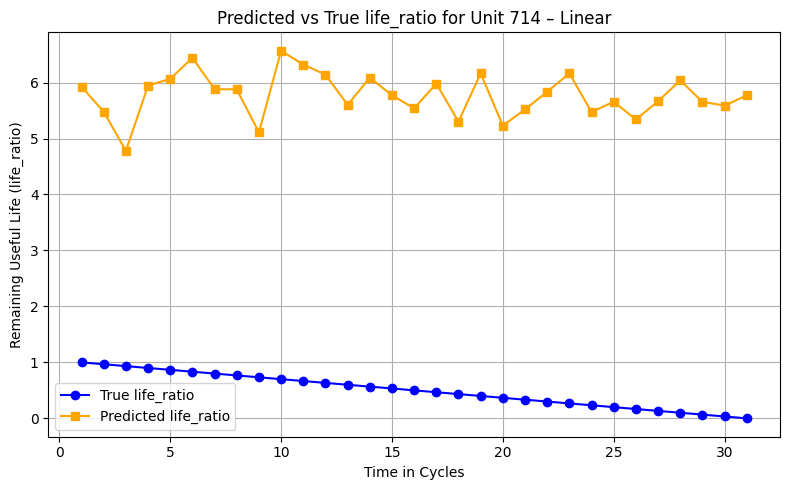

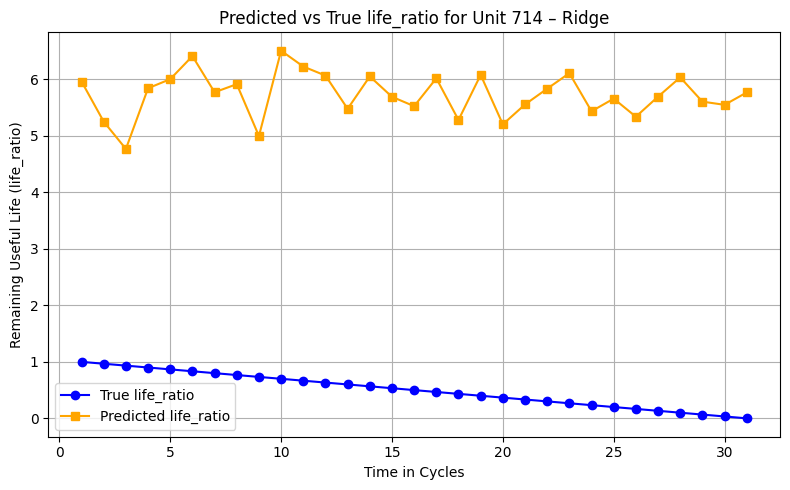

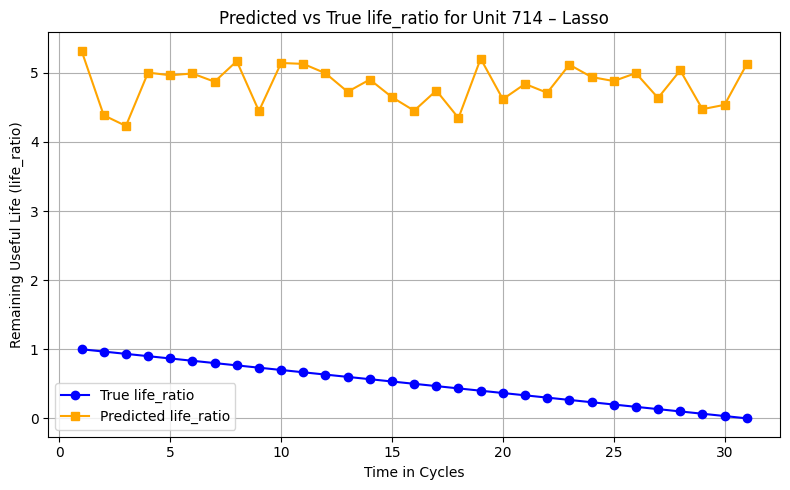

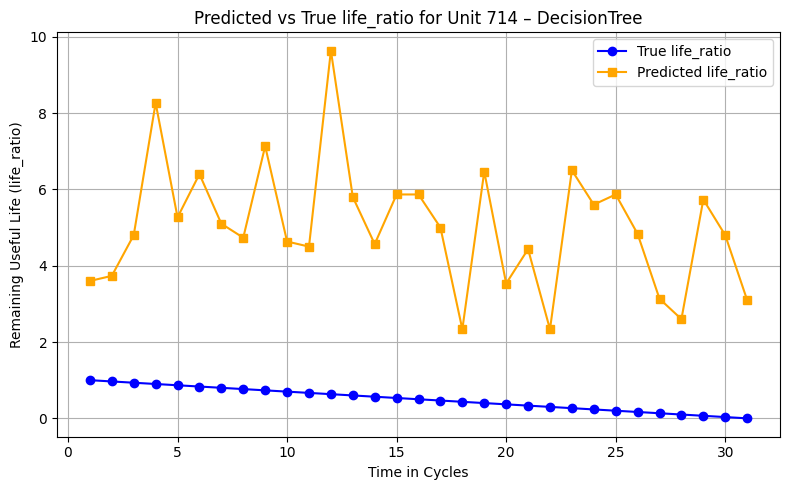

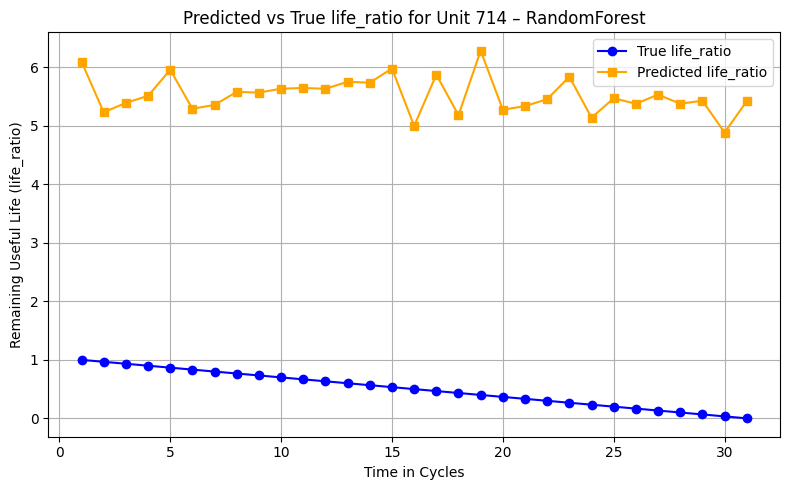

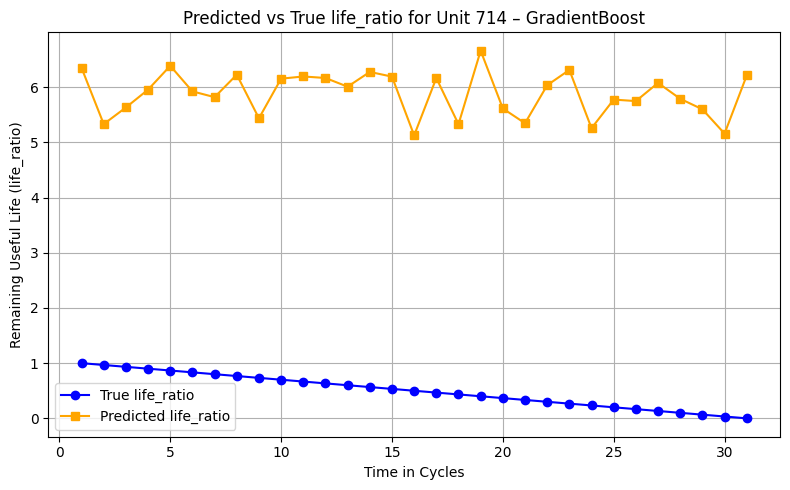

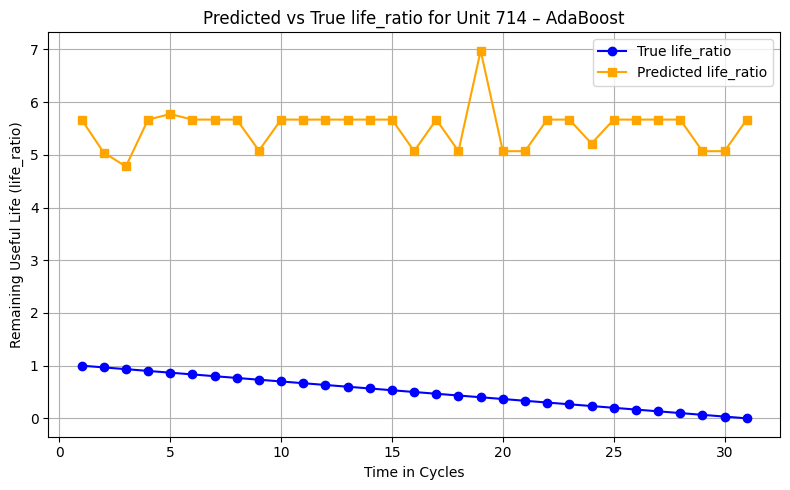

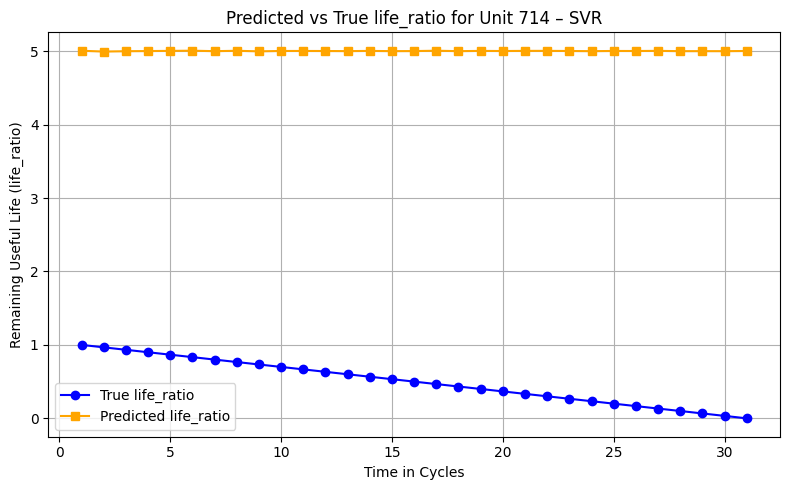

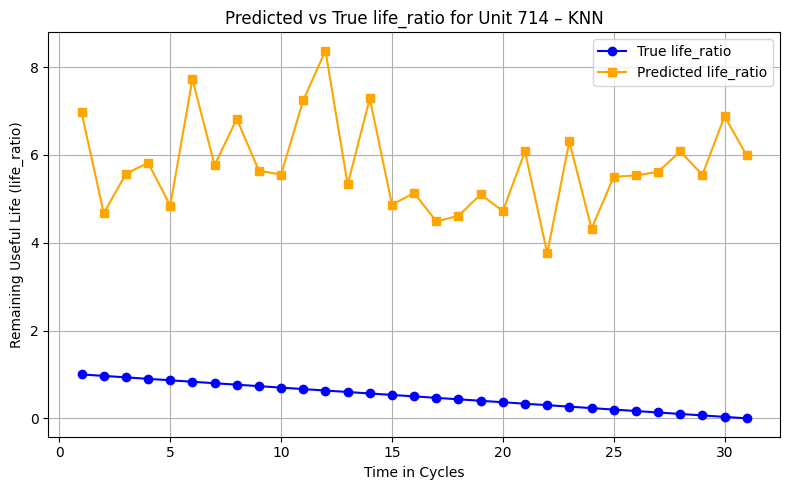

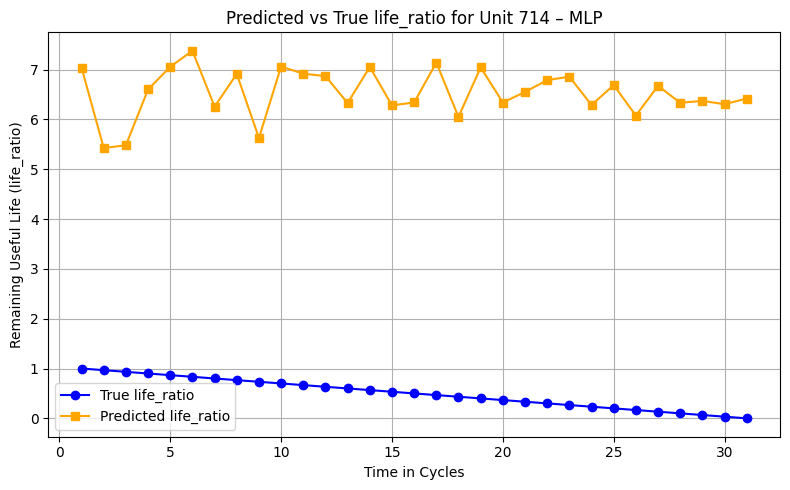

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# ✅ Step 1: Get a valid unit ID from test_df
valid_units = sorted(test_df[0].unique())
print("Available Unit IDs:", valid_units)

# Pick one unit to visualize
unit_id = valid_units[0]  # or change index [1], [2], etc. to visualize different ones

# ✅ Step 2: Get that unit's data
unit_df = test_df[test_df[0] == unit_id].copy()
X_unit = unit_df[sensor_cols]
y_true = unit_df['RUL'].values
time = unit_df[1].values  # 1st column = cycle

# ✅ Step 3: Scale features
X_unit_scaled = scaler.transform(X_unit)

# ✅ Step 4: Normalize RUL → life_ratio
true_life_ratio = y_true / y_true[0]

# ✅ Step 5: Plot for each model
for name in model_names:
    model = trained_models[name]
    y_pred = model.predict(X_unit_scaled)
    pred_life_ratio = y_pred / y_true[0]

    plt.figure(figsize=(8, 5))
    plt.plot(time, true_life_ratio, marker='o', label='True life_ratio', color='blue')
    plt.plot(time, pred_life_ratio, marker='s', label='Predicted life_ratio', color='orange')
    plt.title(f'Predicted vs True life_ratio for Unit {unit_id} – {name}')
    plt.xlabel('Time in Cycles')
    plt.ylabel('Remaining Useful Life (life_ratio)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
